# DATASCI 112 Final Project: Chasing Sunsets

### For my final project, I wanted to know if it was possible to predict when a "good" sunset would occur.

## Data Collection and Cleaning

What is a "good" sunset, anyway?

I used a sunset quality dataset developed at Stanford, tracking number of times the hashtag #sunset was used in 10 cities over 7 months and whether it was a good sunset or not (based on human assessment + computer vision model).

https://cs.stanford.edu/~emmap1/sunset_paper.pdf

I then used a weather API to pull daily sunset times and hourly weather data for each data point.

In [12]:
import pandas as pd
sunsetQuality = pd.read_csv("https://github.com/jenniferxxfung/datasci112/raw/main/sunset_quality_scores.csv")
sunsetQuality
sunsetQuality["City"] = sunsetQuality["City"].str.replace("_", " ")

sunsetQuality

,Unnamed: 0,Date,City,Raw Number of Posts,Residual After Controlling for Time,Good Sunset
0,Los_Angeles2015-11-01,2015-11-01,Los Angeles,365,-0.510703,0.0
1,Los_Angeles2015-11-02,2015-11-02,Los Angeles,625,0.452376,1.0
2,Los_Angeles2015-11-03,2015-11-03,Los Angeles,610,0.493056,1.0
3,Los_Angeles2015-11-04,2015-11-04,Los Angeles,505,0.236023,0.0
4,Los_Angeles2015-11-05,2015-11-05,Los Angeles,376,-0.026923,0.0
...,...,...,...,...,...,...
1786,Seattle2016-05-27,2016-05-27,Seattle,33,-0.545203,0.0
1787,Seattle2016-05-28,2016-05-28,Seattle,74,0.037532,0.0
1788,Seattle2016-05-29,2016-05-29,Seattle,104,0.184662,0.0
1789,Seattle2016-05-30,2016-05-30,Seattle,66,-0.059696,0.0


In [4]:
# Get names of the cities studied in the dataset and manually make dictionary of their corresponding coordinates.
sunsetQuality["City"].unique()

array(['Los Angeles', 'San Francisco', 'Chicago', 'Miami', 'Philadelphia',
       'NYC', 'San Diego', 'Boston', 'Washington DC', 'Seattle'],
      dtype=object)

In [5]:
cityCoordinates = {"Los Angeles": [34.05, -118.24],
                   "San Francisco": [37.73, -122.44], 
                   "San Diego": [32.71, -117.16],
                   "Seattle": [47.60, -122.33],
                   "Chicago": [41.88, -87.62],
                   "Miami": [25.76, -80.19],
                   "Philadelphia": [39.95, -75.16],
                   "NYC": [40.73, -73.93],
                   "Boston": [42.36, -71.05],
                   "Washington DC": [38.89, -77.03]}

In [11]:
import requests
import json
import time

df = pd.DataFrame()

# For each day in the range of dates, get the time that the sunset occurred in each city from a weather API.
for city in cityCoordinates:
  latitude = cityCoordinates[city][0]
  longitude = cityCoordinates[city][1]
  response = requests.get("https://archive-api.open-meteo.com/v1/archive?latitude=" + str(latitude)  + 
                          "&longitude=" + str(longitude) + "&start_date=2015-11-01&end_date=2016-05-31&daily=sunset&timezone=America%2FLos_Angeles&temperature_unit=fahrenheit&windspeed_unit=mph")
  sunsetTimes = response.json()
  df_sunsetTimes = pd.DataFrame(sunsetTimes["daily"])
  # extract sunset time from "sunset" column, add city's name, and rename date column for easier joining purposes later
  df_sunsetTimes["Sunset Time"] = df_sunsetTimes["sunset"].str[11:]
  df_sunsetTimes["City"] = city
  df_sunsetTimes = df_sunsetTimes.rename(columns={"time": "Date"})
  df = pd.concat([df, df_sunsetTimes])
  time.sleep(.5)

df

,Date,sunset,Sunset Time,City
0,2015-11-01,2015-11-01T18:01,18:01,Los Angeles
1,2015-11-02,2015-11-02T18:00,18:00,Los Angeles
2,2015-11-03,2015-11-03T17:59,17:59,Los Angeles
3,2015-11-04,2015-11-04T17:59,17:59,Los Angeles
4,2015-11-05,2015-11-05T17:58,17:58,Los Angeles
...,...,...,...,...
208,2016-05-27,2016-05-27T17:25,17:25,Washington DC
209,2016-05-28,2016-05-28T17:26,17:26,Washington DC
210,2016-05-29,2016-05-29T17:27,17:27,Washington DC
211,2016-05-30,2016-05-30T17:27,17:27,Washington DC


In [13]:
# join sunsetQuality dataset with sunset times dataset
sunsetQuality = sunsetQuality.merge(df, how = "left", on = ["City", "Date"])
sunsetQuality

,Unnamed: 0,Date,City,Raw Number of Posts,Residual After Controlling for Time,Good Sunset,sunset,Sunset Time
0,Los_Angeles2015-11-01,2015-11-01,Los Angeles,365,-0.510703,0.0,2015-11-01T18:01,18:01
1,Los_Angeles2015-11-02,2015-11-02,Los Angeles,625,0.452376,1.0,2015-11-02T18:00,18:00
2,Los_Angeles2015-11-03,2015-11-03,Los Angeles,610,0.493056,1.0,2015-11-03T17:59,17:59
3,Los_Angeles2015-11-04,2015-11-04,Los Angeles,505,0.236023,0.0,2015-11-04T17:59,17:59
4,Los_Angeles2015-11-05,2015-11-05,Los Angeles,376,-0.026923,0.0,2015-11-05T17:58,17:58
...,...,...,...,...,...,...,...,...
1786,Seattle2016-05-27,2016-05-27,Seattle,33,-0.545203,0.0,2016-05-27T20:56,20:56
1787,Seattle2016-05-28,2016-05-28,Seattle,74,0.037532,0.0,2016-05-28T20:57,20:57
1788,Seattle2016-05-29,2016-05-29,Seattle,104,0.184662,0.0,2016-05-29T20:58,20:58
1789,Seattle2016-05-30,2016-05-30,Seattle,66,-0.059696,0.0,2016-05-30T20:59,20:59


In [15]:
# remove extraneous columns
sunsetQuality = sunsetQuality.drop(["Unnamed: 0", "Residual After Controlling for Time", "sunset"], axis=1)
sunsetQuality

,Date,City,Raw Number of Posts,Good Sunset,Sunset Time
0,2015-11-01,Los Angeles,365,0.0,18:01
1,2015-11-02,Los Angeles,625,1.0,18:00
2,2015-11-03,Los Angeles,610,1.0,17:59
3,2015-11-04,Los Angeles,505,0.0,17:59
4,2015-11-05,Los Angeles,376,0.0,17:58
...,...,...,...,...,...
1786,2016-05-27,Seattle,33,0.0,20:56
1787,2016-05-28,Seattle,74,0.0,20:57
1788,2016-05-29,Seattle,104,0.0,20:58
1789,2016-05-30,Seattle,66,0.0,20:59


In [16]:
hourlyWeatherData = pd.DataFrame()

# get hourly weather data in each city over range of dates in dataset
for city in cityCoordinates:
  latitude = cityCoordinates[city][0]
  longitude = cityCoordinates[city][1]
  response = requests.get(
      "https://archive-api.open-meteo.com/v1/archive?latitude=" + str(latitude) 
                          + "&longitude=" + str(longitude) + 
                          "&start_date=2015-11-01&end_date=2016-05-31&hourly=relativehumidity_2m,dewpoint_2m,pressure_msl,surface_pressure,rain,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,windspeed_10m,winddirection_10m,et0_fao_evapotranspiration,vapor_pressure_deficit&timezone=America%2FLos_Angeles&temperature_unit=fahrenheit&windspeed_unit=mph")
  
  weatherData = response.json()
  df_weatherData = pd.DataFrame(weatherData["hourly"])
  # make date and hour columns from time column, and city column for name of city
  df_weatherData["Date"] = df_weatherData["time"].str[:10]
  df_weatherData["Hour"] = df_weatherData["time"].str[11:]
  df_weatherData["City"] = city
  hourlyWeatherData = pd.concat([df_weatherData, hourlyWeatherData])
  time.sleep(.5)

hourlyWeatherData

,time,relativehumidity_2m,dewpoint_2m,pressure_msl,surface_pressure,rain,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,...,direct_radiation,diffuse_radiation,direct_normal_irradiance,windspeed_10m,winddirection_10m,et0_fao_evapotranspiration,vapor_pressure_deficit,Date,Hour,City
0,2015-11-01T00:00,69,43.3,1016.2,1010.5,0.0,89,0,100,96,...,0.0,0.0,0.0,6.9,199,0.03,0.43,2015-11-01,00:00,Washington DC
1,2015-11-01T01:00,69,43.8,1015.8,1010.1,0.0,90,0,100,100,...,0.0,0.0,0.0,7.2,196,0.03,0.43,2015-11-01,01:00,Washington DC
2,2015-11-01T02:00,74,45.2,1015.4,1009.7,0.1,90,1,100,96,...,0.0,0.0,0.0,8.0,193,0.03,0.37,2015-11-01,02:00,Washington DC
3,2015-11-01T03:00,75,45.9,1015.2,1009.5,0.0,96,7,100,100,...,0.0,0.0,0.0,8.3,199,0.02,0.35,2015-11-01,03:00,Washington DC
4,2015-11-01T04:00,78,46.9,1015.1,1009.4,0.2,100,32,100,50,...,0.0,0.0,0.0,8.9,202,0.02,0.31,2015-11-01,04:00,Washington DC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5107,2016-05-31T19:00,51,53.1,1010.2,993.4,0.0,3,0,0,10,...,163.0,58.0,655.6,6.0,211,0.17,1.33,2016-05-31,19:00,Los Angeles
5108,2016-05-31T20:00,61,53.6,1011.0,994.1,0.0,3,0,0,10,...,27.0,21.0,342.7,5.6,214,0.06,0.91,2016-05-31,20:00,Los Angeles
5109,2016-05-31T21:00,68,53.9,1011.3,994.3,0.0,2,2,0,1,...,0.0,0.0,0.0,4.2,212,0.02,0.66,2016-05-31,21:00,Los Angeles
5110,2016-05-31T22:00,73,54.1,1011.7,994.6,0.0,5,5,0,0,...,0.0,0.0,0.0,3.0,197,0.00,0.53,2016-05-31,22:00,Los Angeles


In [19]:
# we don't want weather data for all 24 hours of the day, just the hour that the sunset occurred
sunsetQuality["Hour"] = sunsetQuality["Sunset Time"].str[:2] + ":00"
sunsetData = sunsetQuality.merge(hourlyWeatherData, how = "left", on = ["City", "Date", "Hour"])
sunsetData = sunsetData.drop(["time", "Hour"], axis = 1)
sunsetData

,Date,City,Raw Number of Posts,Good Sunset,Sunset Time,relativehumidity_2m,dewpoint_2m,pressure_msl,surface_pressure,rain,...,cloudcover_mid,cloudcover_high,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,windspeed_10m,winddirection_10m,et0_fao_evapotranspiration,vapor_pressure_deficit
0,2015-11-01,Los Angeles,365,0.0,18:01,36,47.6,1013.4,996.7,0.0,...,0,0,61.0,39.0,22.0,426.1,3.9,211,0.08,1.97
1,2015-11-02,Los Angeles,625,1.0,18:00,76,56.1,1007.8,990.8,0.2,...,67,0,32.0,17.0,15.0,321.7,12.4,256,0.07,0.48
2,2015-11-03,Los Angeles,610,1.0,17:59,38,38.6,1008.9,991.9,0.0,...,36,0,205.0,118.0,87.0,469.6,6.7,268,0.17,1.31
3,2015-11-04,Los Angeles,505,0.0,17:59,38,39.1,1013.8,996.8,0.0,...,0,0,227.0,170.0,57.0,591.4,8.9,270,0.20,1.34
4,2015-11-05,Los Angeles,376,0.0,17:58,14,17.8,1019.5,1002.5,0.0,...,0,12,234.0,178.0,56.0,756.8,6.0,248,0.21,2.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1786,2016-05-27,Seattle,33,0.0,20:56,67,44.4,1019.6,1017.5,0.2,...,66,92,79.0,26.0,53.0,129.4,2.8,225,0.06,0.50
1787,2016-05-28,Seattle,74,0.0,20:57,80,49.4,1016.6,1014.5,0.3,...,92,1,21.0,2.0,19.0,9.1,5.5,207,0.04,0.31
1788,2016-05-29,Seattle,104,0.0,20:58,66,46.0,1022.1,1020.0,0.0,...,27,0,113.0,63.0,50.0,359.4,3.7,14,0.07,0.54
1789,2016-05-30,Seattle,66,0.0,20:59,57,46.2,1021.9,1019.9,0.0,...,0,67,153.0,99.0,54.0,580.8,5.6,358,0.10,0.80


## Data Exploration

In [20]:
# considered standardizing weather variables
sunsetData["vapor_pressure_deficit"] - (sunsetData["vapor_pressure_deficit"].mean()/sunsetData["vapor_pressure_deficit"].std())

0       0.768658
1      -0.721342
2       0.108658
3       0.138658
4       0.968658
          ...   
1786   -0.701342
1787   -0.891342
1788   -0.661342
1789   -0.401342
1790   -0.491342
Name: vapor_pressure_deficit, Length: 1791, dtype: float64

In [21]:
# get list of weather variables used
features = sunsetData.drop(["City", "Date", "Good Sunset", "Sunset Time", "Raw Number of Posts"], axis = 1).columns.values.tolist()
features

['relativehumidity_2m',
 'dewpoint_2m',
 'pressure_msl',
 'surface_pressure',
 'rain',
 'cloudcover',
 'cloudcover_low',
 'cloudcover_mid',
 'cloudcover_high',
 'shortwave_radiation',
 'direct_radiation',
 'diffuse_radiation',
 'direct_normal_irradiance',
 'windspeed_10m',
 'winddirection_10m',
 'et0_fao_evapotranspiration',
 'vapor_pressure_deficit']

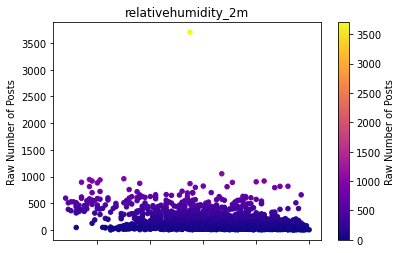

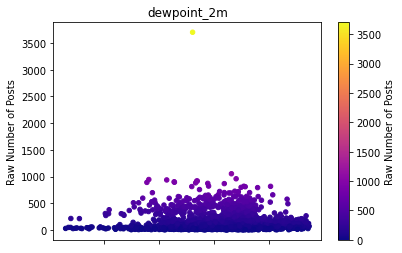

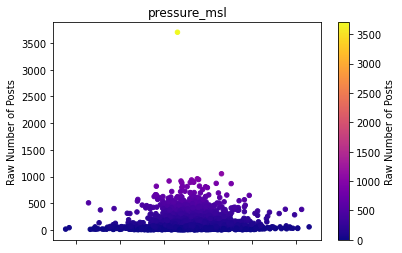

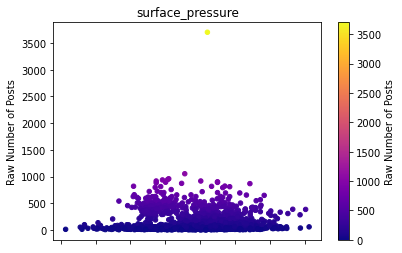

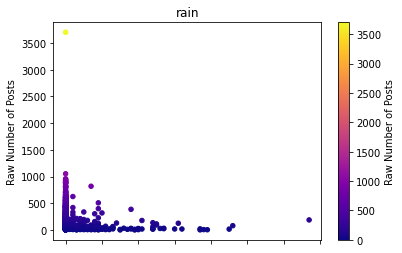

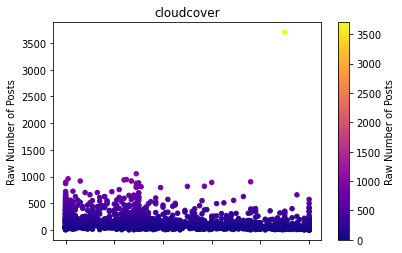

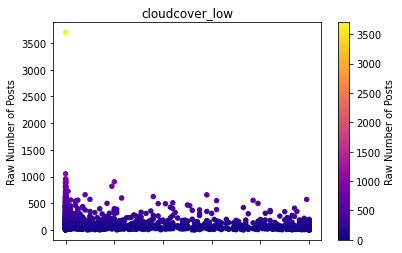

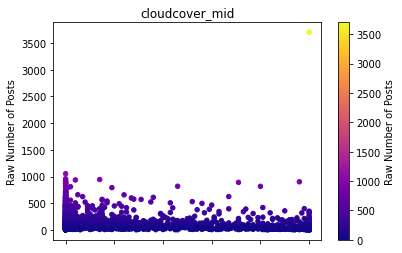

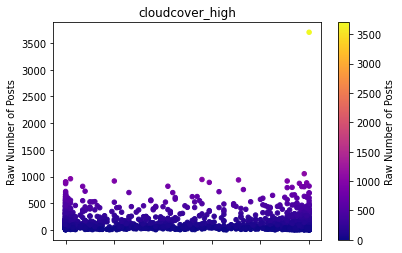

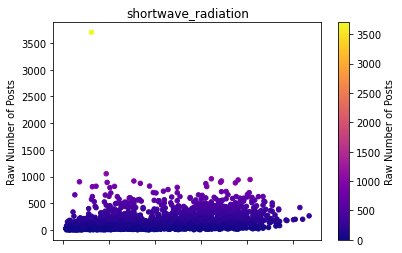

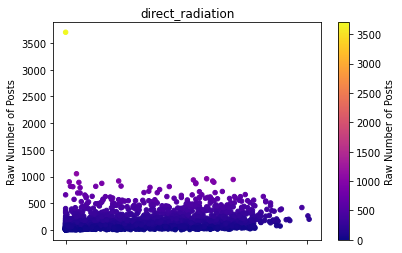

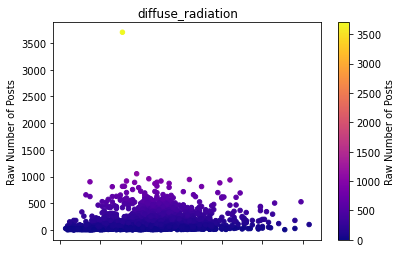

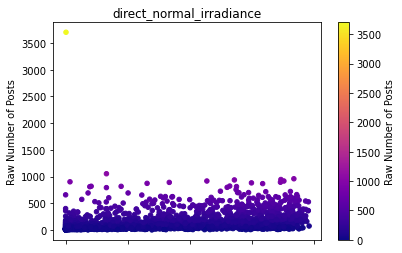

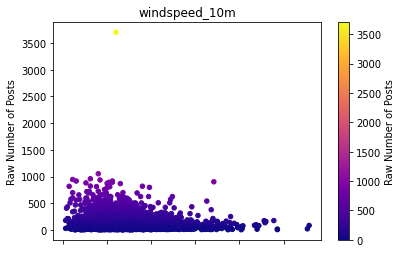

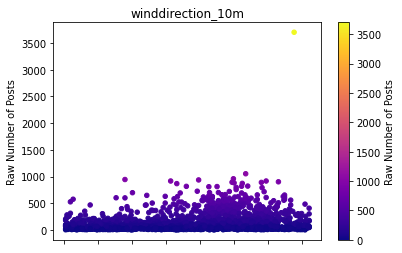

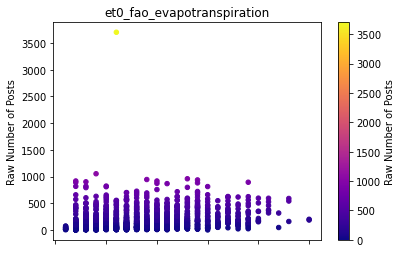

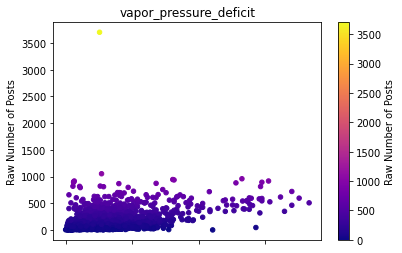

In [24]:
# tried to visualize relationship between number of #sunset posts and weather variables,
# but what's that outlier?
for feature in features:
  sunsetData.plot.scatter(x = feature, y = "Raw Number of Posts", c = "Raw Number of Posts", colormap = "plasma", title = feature)

In [25]:
# turns out that New York had a record breaking 3702 posts using #sunset on Nov 22, 2015
sunsetData["Raw Number of Posts"].max()

3702

These scatter plots told me that a nice sunset can generally happen under the same weather conditions as a mediocre sunset.

However, there are certain conditions that act as qualifiers or disqualifiers for a good sunset. If met, there is a possibility for a high volume of #sunset posts for that day, or conversely, it will be unlikely to see a high number of #sunset posts. 

For example:

-relative humidity: #sunset gets used across varying humidity levels, but if humidity is low, it's unlikely that there will be a low volume of #sunset posts that day. The same can be observed for a high vapor pressure deficit.

-wind speed: on days with high windspeed, it's unlikely to see a high volume of #sunset posts

-wind direction: on the other hand, high wind direction values yield high (and low) volumes of #sunset posts, but low wind direction value generally means it's unlikely to see many #sunset posts

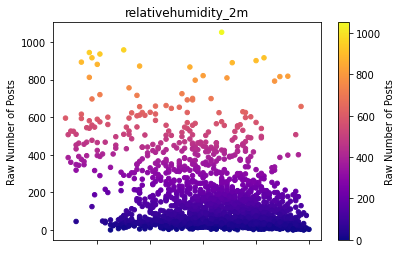

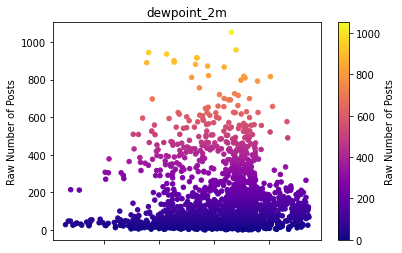

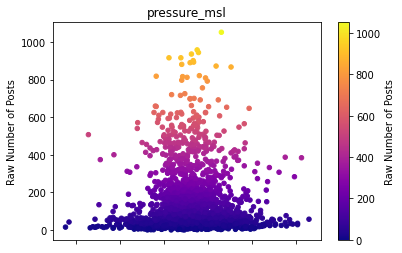

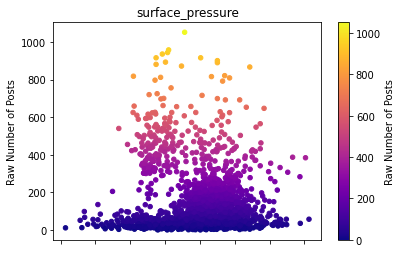

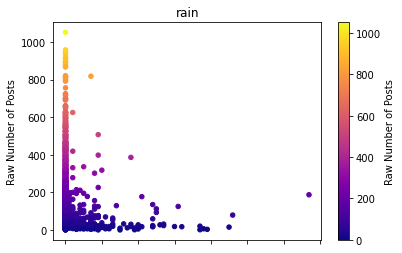

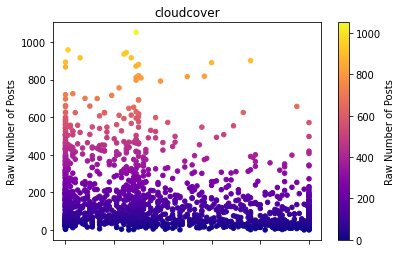

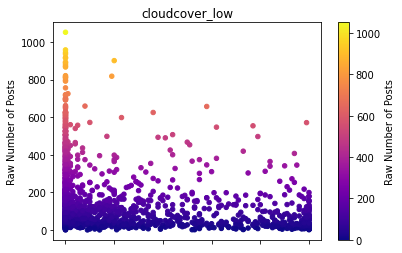

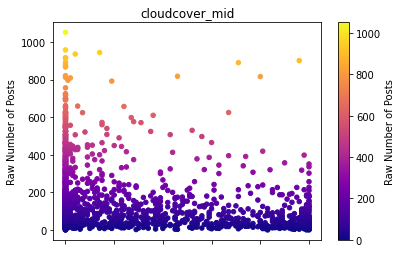

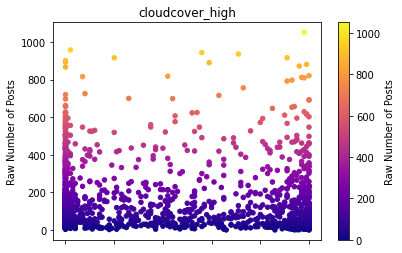

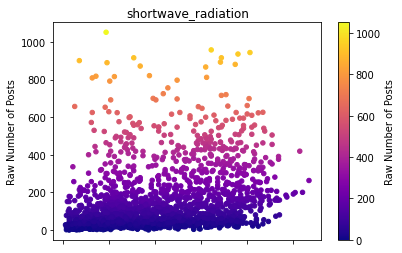

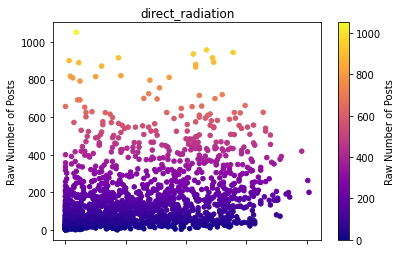

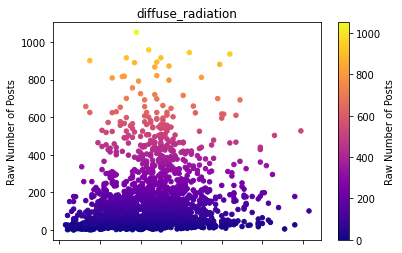

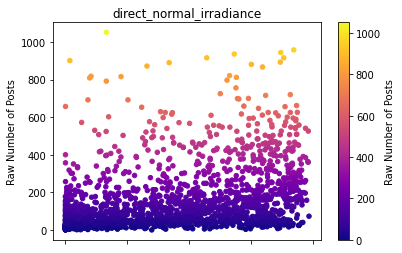

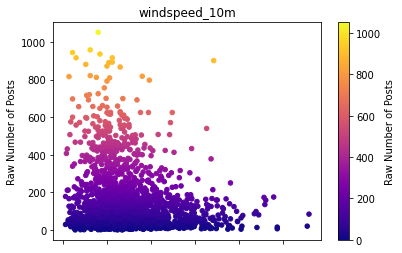

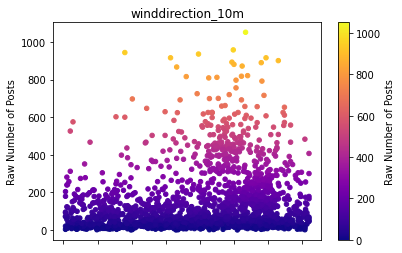

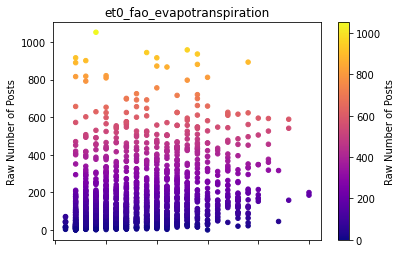

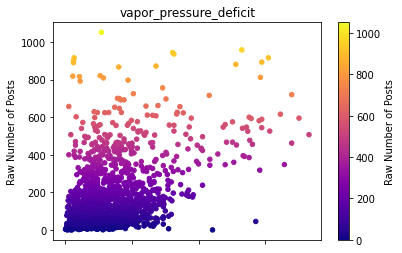

In [36]:
# cool sunset, but let's exclude this outlier so we can better see the data
sunsetData = sunsetData[sunsetData["Raw Number of Posts"] < 3702]

for feature in features:
  sunsetData.plot.scatter(x = feature, y = "Raw Number of Posts", c = "Raw Number of Posts", colormap = "plasma", title = feature)

In [48]:
# after unsuccessfully training a model to predict number of #sunset posts, I decided to take a
# look at what the good sunset rows could tell me and realized that social media activity
# varies from city to city and isn't a good metric for determining whether a sunset is good or not

# instead, use binary classification on the "Good Sunset" column
goodSunsets = sunsetData[sunsetData["Good Sunset"] == 1.0]
goodSunsets

,City,Date,Good Sunset,Sunset Time,Raw Number of Posts,relativehumidity_2m,dewpoint_2m,pressure_msl,surface_pressure,rain,...,cloudcover_mid,cloudcover_high,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,windspeed_10m,winddirection_10m,et0_fao_evapotranspiration,vapor_pressure_deficit
1,Los Angeles,2015-11-02,1.0,18:00,625,76,56.1,1007.8,990.8,0.2,...,67,0,32.0,17.0,15.0,321.7,12.4,256,0.07,0.48
2,Los Angeles,2015-11-03,1.0,17:59,610,38,38.6,1008.9,991.9,0.0,...,36,0,205.0,118.0,87.0,469.6,6.7,268,0.17,1.31
26,Los Angeles,2015-11-28,1.0,17:45,697,18,17.7,1016.0,998.8,0.0,...,0,0,124.0,76.0,48.0,559.3,1.1,101,0.07,1.51
35,Los Angeles,2015-12-07,1.0,17:45,893,14,25.7,1016.8,1000.1,0.0,...,0,0,171.0,123.0,48.0,693.1,5.6,247,0.19,2.95
36,Los Angeles,2015-12-08,1.0,17:45,812,17,32.0,1015.3,998.7,0.0,...,0,97,156.0,86.0,70.0,551.3,3.8,225,0.15,2.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1769,Seattle,2016-05-10,1.0,20:35,215,36,37.9,1020.6,1018.6,0.0,...,0,39,114.0,76.0,38.0,590.5,3.1,21,0.08,1.37
1770,Seattle,2016-05-11,1.0,20:37,155,35,40.6,1012.9,1010.9,0.0,...,0,0,114.0,76.0,38.0,580.3,3.5,310,0.09,1.60
1771,Seattle,2016-05-12,1.0,20:38,164,38,43.0,1014.9,1012.9,0.0,...,0,23,118.0,79.0,39.0,569.7,1.6,326,0.06,1.57
1772,Seattle,2016-05-13,1.0,20:39,174,50,53.2,1010.8,1008.8,0.0,...,46,8,101.0,51.0,50.0,416.2,5.2,355,0.11,1.41


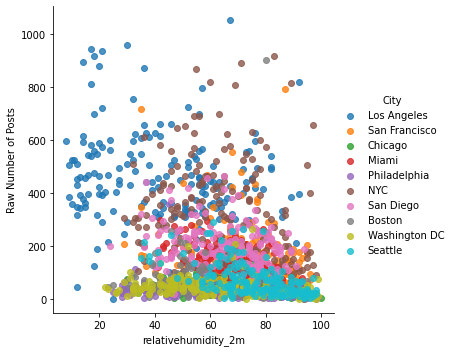

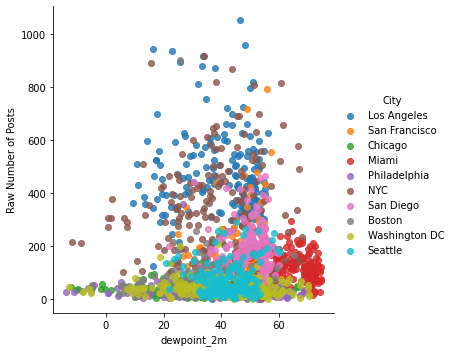

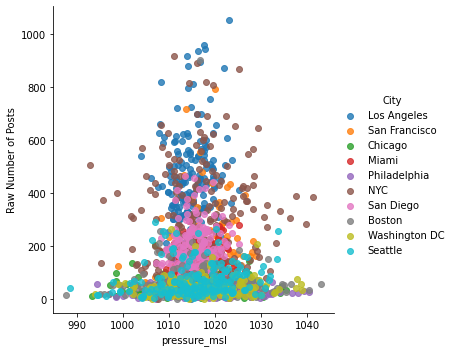

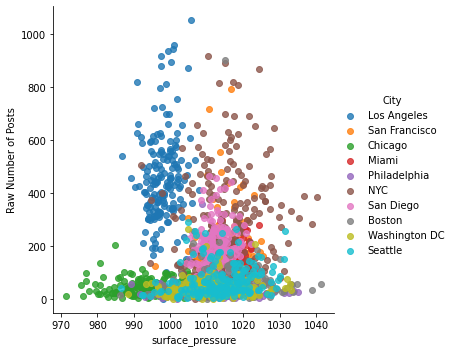

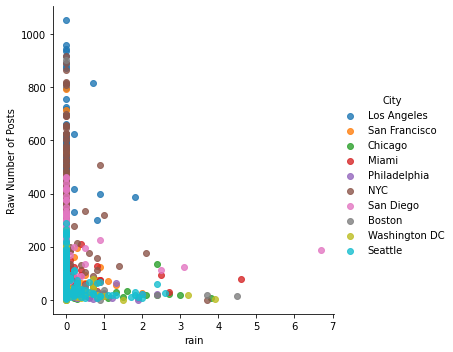

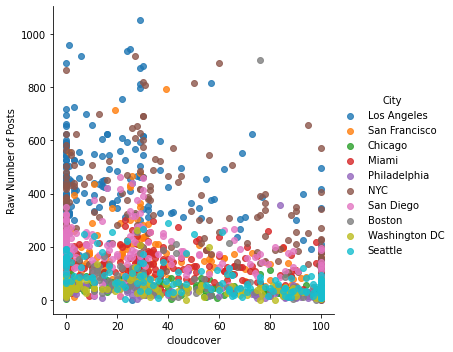

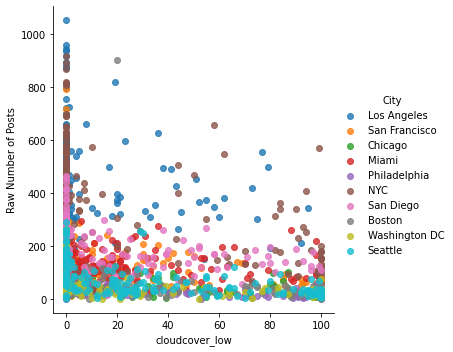

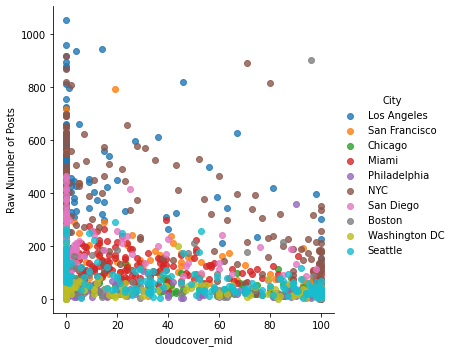

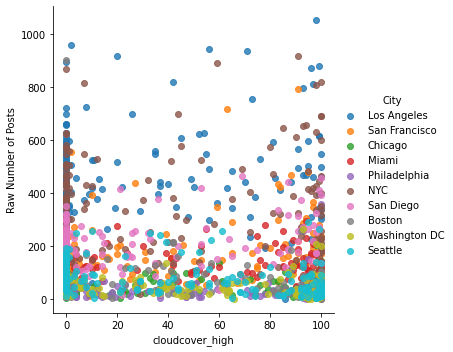

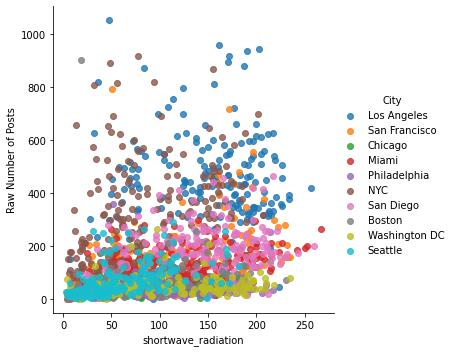

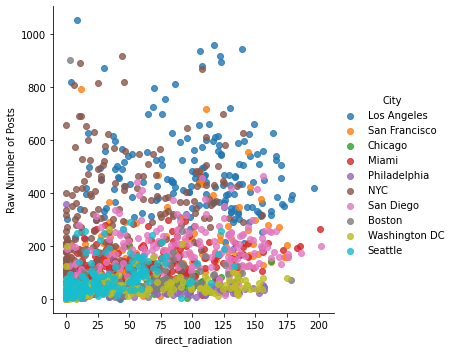

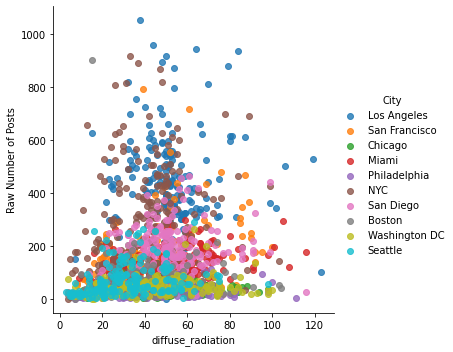

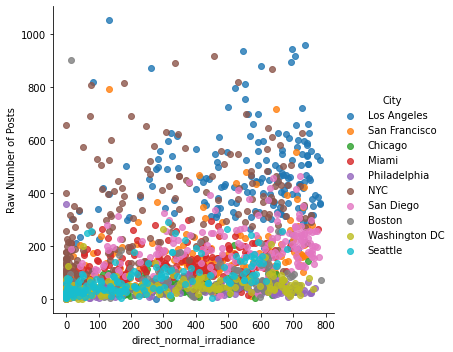

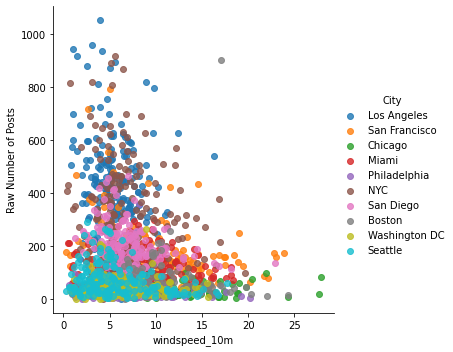

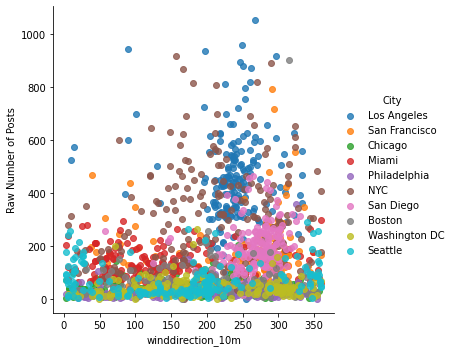

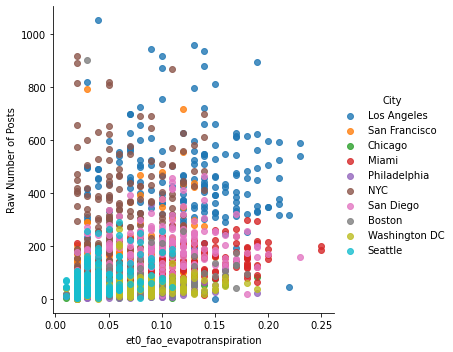

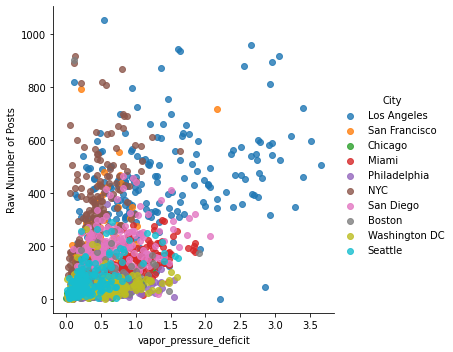

In [38]:
import seaborn as sb
import matplotlib.pyplot as plt
 
for feature in features:
  sb.lmplot( x=feature, y="Raw Number of Posts", data=sunsetData, fit_reg=False, hue='City', legend=True)
  plt.show()

# Machine Learning 

In [47]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

In [49]:
# uh oh (don't use raw number of posts as y)

X = sunsetData[features]
y_bad = sunsetData["Raw Number of Posts"]
X_train, X_test, y_train, y_test = train_test_split(X, y_bad, test_size = .33)

scalers = [StandardScaler, MinMaxScaler, Normalizer]
distanceMetrics = ["manhattan", "minkowski", "hamming", "euclidean"]

for scaler in scalers:
  for distanceMetric in distanceMetrics:
    col_transformer = make_column_transformer((scaler(), features),
                                              remainder="drop")
    pipeline = make_pipeline(col_transformer, KNeighborsRegressor(n_neighbors=20, metric = distanceMetric))
    print(scaler, distanceMetric, -cross_val_score(
        pipeline, X_train, y_train,
        scoring = "neg_mean_squared_error",
        cv=4).mean())

<class 'sklearn.preprocessing._data.StandardScaler'> manhattan 18851.950168324973
<class 'sklearn.preprocessing._data.StandardScaler'> minkowski 19029.545068011423
<class 'sklearn.preprocessing._data.StandardScaler'> hamming 24201.917040001394
<class 'sklearn.preprocessing._data.StandardScaler'> euclidean 19029.545068011423
<class 'sklearn.preprocessing._data.MinMaxScaler'> manhattan 19710.530994035675
<class 'sklearn.preprocessing._data.MinMaxScaler'> minkowski 20247.85425032748
<class 'sklearn.preprocessing._data.MinMaxScaler'> hamming 24201.917040001394
<class 'sklearn.preprocessing._data.MinMaxScaler'> euclidean 20247.85425032748
<class 'sklearn.preprocessing._data.Normalizer'> manhattan 22158.61443492196
<class 'sklearn.preprocessing._data.Normalizer'> minkowski 22221.38676878484
<class 'sklearn.preprocessing._data.Normalizer'> hamming 29988.897132657472
<class 'sklearn.preprocessing._data.Normalizer'> euclidean 22221.38676878484


In [55]:
# Better!

X = sunsetData[features]
y = sunsetData["Good Sunset"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33)

scalers = [StandardScaler, MinMaxScaler, Normalizer]
distanceMetrics = ["manhattan", "minkowski", "hamming", "euclidean"]

for scaler in scalers:
  for distanceMetric in distanceMetrics:
    col_transformer = make_column_transformer((scaler(), features),
                                              remainder="drop")
    pipeline = make_pipeline(col_transformer, KNeighborsRegressor(n_neighbors=20, metric = distanceMetric))
    print(scaler, distanceMetric, -cross_val_score(
        pipeline, X_train, y_train,
        scoring = "neg_mean_squared_error",
        cv=4).mean())

<class 'sklearn.preprocessing._data.StandardScaler'> manhattan 0.10756394927536232
<class 'sklearn.preprocessing._data.StandardScaler'> minkowski 0.1058142488851728
<class 'sklearn.preprocessing._data.StandardScaler'> hamming 0.11483712374581938
<class 'sklearn.preprocessing._data.StandardScaler'> euclidean 0.1058142488851728
<class 'sklearn.preprocessing._data.MinMaxScaler'> manhattan 0.10846898690078038
<class 'sklearn.preprocessing._data.MinMaxScaler'> minkowski 0.10807835144927537
<class 'sklearn.preprocessing._data.MinMaxScaler'> hamming 0.11483712374581938
<class 'sklearn.preprocessing._data.MinMaxScaler'> euclidean 0.10807835144927537
<class 'sklearn.preprocessing._data.Normalizer'> manhattan 0.11207872073578595
<class 'sklearn.preprocessing._data.Normalizer'> minkowski 0.11394167363433667
<class 'sklearn.preprocessing._data.Normalizer'> hamming 0.1277399317168339
<class 'sklearn.preprocessing._data.Normalizer'> euclidean 0.11394167363433667


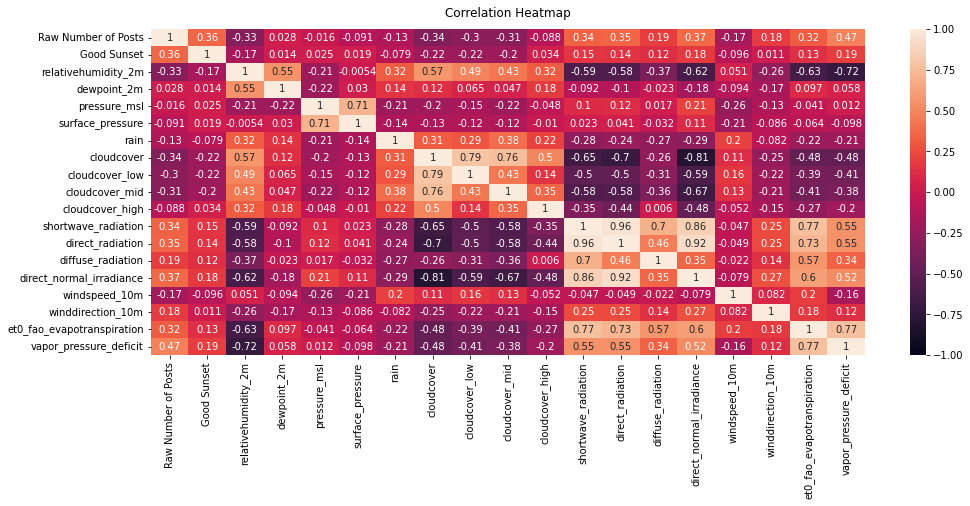

In [52]:
pearsoncorr = sunsetData.corr(method='pearson')
pearsoncorr
plt.figure(figsize=(16, 6))
heatmap = sb.heatmap(sunsetData.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [56]:
ks, test_mses = range(2, 100, 2), []
train_mses = []

col_transformer = make_column_transformer((StandardScaler(), features))

for k in ks:
  bestPipeline = make_pipeline(
    col_transformer,
    KNeighborsRegressor(n_neighbors=k, metric="euclidean"))
  
  bestPipeline.fit(X_train, y_train)
  y_train_ = bestPipeline.predict(X_train)
  train_mses.append(mean_squared_error(y_train, y_train_))
  
  test_mses.append(-cross_val_score(
    bestPipeline, X_train, y_train,
    scoring="neg_mean_squared_error", cv=4).mean())

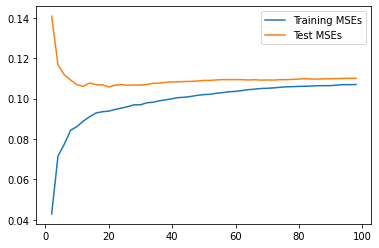

In [57]:
plt.plot(ks, train_mses, label = "Training MSEs")
plt.plot(ks, test_mses, label = "Test MSEs")
plt.legend(loc = "upper right")

In [58]:
pd.Series(test_mses, index = ks).idxmin()

20

In [82]:
bestPipeline = make_pipeline(
    col_transformer,
    KNeighborsRegressor(n_neighbors=20, metric="euclidean"))
  
bestPipeline.fit(X_train, y_train)
print(-cross_val_score(
        pipeline, X_train, y_train,
        scoring = "neg_mean_squared_error",
        cv=4).mean())
y_pred = bestPipeline.predict(X_train)
mean_squared_error(y_train, y_pred, squared = False)

0.1279331270506161


0.3062900498909792

In [64]:
from sklearn.tree import DecisionTreeRegressor

pipeline = make_pipeline(col_transformer, DecisionTreeRegressor(max_depth=7, min_samples_leaf=6))

test_mse_tree = -cross_val_score(pipeline, 
                            X_train, 
                            y_train, 
                            scoring="neg_mean_squared_error", cv=5).mean()

print(test_mse_tree)

0.12884830694009908


In [70]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV

clf = RandomForestClassifier(n_estimators = 100)  
clf.fit(X_train, y_train)
print(-cross_val_score(
      clf, X_train, y_train,
      scoring = "neg_mean_squared_error",
      cv=5).mean())
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

0.12844142259414223
Accuracy: 0.8240270727580372


In [67]:
# hyperparameter tuning

param_grid = {
    'n_estimators': [25, 50, 100, 150],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [3, 6, 9],
}
random_search = RandomizedSearchCV(RandomForestClassifier(),
                                   param_grid)
random_search.fit(X_train, y_train)
print(random_search.best_estimator_)

RandomForestClassifier(max_depth=9, max_features='log2', max_leaf_nodes=9,
                       n_estimators=50)


In [68]:
# let's try with new hyperparameters

clf = RandomForestClassifier(max_depth=9, max_features='log2', max_leaf_nodes=9,
                       n_estimators=50)  
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8358714043993232


Testing if my model can "predict" my favorite Stanford sunsets of winter quarter!

In [86]:
response = requests.get("https://archive-api.open-meteo.com/v1/archive?latitude=" + "37.42"  + 
                          "&longitude=" + "-122.16" + "&start_date=2023-01-01&end_date=2023-03-10&daily=sunset&timezone=America%2FLos_Angeles&temperature_unit=fahrenheit&windspeed_unit=mph")
sunsetTimes = response.json()
df_sunsetTimes = pd.DataFrame(sunsetTimes["daily"])
df_sunsetTimes["Sunset Time"] = df_sunsetTimes["sunset"].str[11:]
df_sunsetTimes = df_sunsetTimes.rename(columns={"time": "Date"})
df_sunsetTimes

,Date,sunset,Sunset Time
0,2023-01-01,2023-01-01T18:03,18:03
1,2023-01-02,2023-01-02T18:03,18:03
2,2023-01-03,2023-01-03T18:04,18:04
3,2023-01-04,2023-01-04T18:05,18:05
4,2023-01-05,2023-01-05T18:06,18:06
...,...,...,...
64,2023-03-06,2023-03-06T19:08,19:08
65,2023-03-07,2023-03-07T19:09,19:09
66,2023-03-08,2023-03-08T19:10,19:10
67,2023-03-09,2023-03-09T19:11,19:11


In [87]:
hourlyWeatherData = pd.DataFrame()

response = requests.get(
      "https://archive-api.open-meteo.com/v1/archive?latitude=" + "37.42" 
                          + "&longitude=" + "-122.16" + 
                          "&start_date=2023-01-01&end_date=2023-03-20&hourly=relativehumidity_2m,dewpoint_2m,pressure_msl,surface_pressure,rain,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,windspeed_10m,winddirection_10m,et0_fao_evapotranspiration,vapor_pressure_deficit&timezone=America%2FLos_Angeles&temperature_unit=fahrenheit&windspeed_unit=mph")
weatherData = response.json()
df_weatherData = pd.DataFrame(weatherData["hourly"])
df_weatherData["Date"] = df_weatherData["time"].str[:10]
df_weatherData["Hour"] = df_weatherData["time"].str[11:]
hourlyWeatherData = pd.concat([df_weatherData, hourlyWeatherData])
time.sleep(.5)

hourlyWeatherData

df_sunsetTimes["Hour"] = df_sunsetTimes["Sunset Time"].str[:2] + ":00"
sunsetData_STANFORD = df_sunsetTimes.merge(hourlyWeatherData, how = "left", on = ["Date", "Hour"])
sunsetData_STANFORD = sunsetData_STANFORD.drop(["time", "Hour"], axis = 1)

In [88]:
stanfordTest = sunsetData_STANFORD[features]
stanfordTest

,relativehumidity_2m,dewpoint_2m,pressure_msl,surface_pressure,rain,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,windspeed_10m,winddirection_10m,et0_fao_evapotranspiration,vapor_pressure_deficit
0,76.0,45.3,1012.1,1003.8,0.0,9.0,0.0,0.0,30.0,55.0,35.0,20.0,420.3,7.4,319.0,0.03,0.33
1,82.0,44.2,1008.0,999.6,1.1,100.0,83.0,84.0,0.0,12.0,4.0,8.0,133.7,10.1,122.0,0.04,0.21
2,80.0,46.2,1015.2,1006.8,0.0,66.0,11.0,93.0,0.0,31.0,5.0,26.0,43.5,4.5,127.0,0.03,0.27
3,89.0,51.5,1003.1,994.9,1.6,100.0,68.0,100.0,100.0,16.0,2.0,14.0,2.8,21.5,163.0,0.04,0.16
4,88.0,47.0,1016.3,1007.9,0.2,40.0,19.0,30.0,17.0,51.0,27.0,24.0,228.0,7.8,237.0,0.02,0.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,76.0,39.5,1020.9,1012.4,0.0,56.0,33.0,44.0,0.0,66.0,37.0,29.0,317.3,3.8,208.0,0.03,0.26
65,73.0,38.9,1020.8,1012.3,0.0,35.0,13.0,38.0,0.0,71.0,43.0,28.0,386.5,3.0,253.0,0.03,0.31
66,71.0,38.8,1020.8,1012.3,0.0,0.0,0.0,0.0,0.0,91.0,61.0,30.0,508.5,3.3,254.0,0.03,0.33
67,93.0,47.0,1007.9,999.5,3.1,100.0,100.0,98.0,100.0,6.0,0.0,6.0,6.5,17.5,169.0,0.02,0.08


In [92]:
prediction = bestPipeline.predict(stanfordTest)
prediction = pd.DataFrame(prediction)

In [ ]:
sunsetData_STANFORD = sunsetData_STANFORD.merge(prediction)